<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/CV_Gan/gan_hw_cond_conv_clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### WGAN

* Модифицируйте код ячеек ниже и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) с клиппингом весов. (10 баллов)

* Замените клиппинг весов на [штраф градентов](https://arxiv.org/pdf/1704.00028v3.pdf). (10 баллов)

* Добавьте лейблы в WGAN, тем самым решая задачу [условной генерации](https://arxiv.org/pdf/1411.1784.pdf). (30 баллов)

Добавьте в этот файл анализ полученных результатов с различными графиками обучения и визуализацию генерации. Сравните как работает клиппинг весов и штраф градиентов и попробуйте пронаблюдать какие недостатки имеет модель GAN.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Простой конфиг (для хранения параметров, можете использовать и модифицировать)

In [ ]:
IMG_ROWS,IMG_COLS = 28, 28

class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 15
config.noise_size = IMG_ROWS*IMG_COLS
config.print_freq = 500
config.latent_dims = 36
config.capacity = 64
config.n_critic = 5

### Создаем dataloader

In [ ]:
img_transform = torchvision.transforms.Compose([
    torchvision.transforms.ColorJitter(brightness=.1, contrast=.1),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5,), (0.5,))
])


train = torchvision.datasets.FashionMNIST("fashion_mnist",
                                          train=True,
                                          transform=img_transform,
                                          download=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 11217844.20it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 204609.16it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3741455.36it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22077992.83it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [ ]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)
len(dataloader)

3750

In [ ]:
image, label = next(iter(dataloader))
image.size(), label

(torch.Size([16, 1, 28, 28]),
 tensor([7, 1, 7, 0, 7, 5, 2, 9, 1, 9, 0, 5, 0, 9, 1, 2]))

### Создаем модель GAN

#### Generator with CONV encoder




In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = config.capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=config.latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, nun_classes, embedding_dim):
        super(Decoder, self).__init__()
        c = config.capacity
        self.embedding = nn.Embedding(nun_classes, embedding_dim)
        self.fc = nn.Linear(in_features=config.latent_dims+embedding_dim, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1)

    def forward(self, input, label):
        #print('decoder_input', input.shape)
        #embed label
        label = self.embedding(label)
        #print('label', label.shape)
        #concatenate image vector and label
        to_decode = torch.cat([input, label], 1)
        #print('to_decode', to_decode.shape)
        x = self.fc(to_decode)
        #print('x', x.shape)
        x = x.view(x.size(0), config.capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        #print('x', x.shape)
        x = F.relu(self.conv2(x))
        #print('x', x.shape)
        x = self.conv1(x)
        x = self.conv(x)
        #print('x', x.shape)
        return x

class Generator(nn.Module):
    def __init__(self, nun_classes, embedding_dim):
        super(Generator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(nun_classes, embedding_dim)

    def forward(self, input, label):
        #print('ecoder_input', input.shape)
        latent = self.encoder(input)
        #print('latent', latent.shape)
        x_recon = self.decoder(latent, label)
        return x_recon


#### Discriminator




In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nun_classes, embedding_dim):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(nun_classes, embedding_dim)

        self.model = nn.Sequential(
            nn.Linear(config.noise_size + embedding_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
            #nn.Sigmoid()
            )
    def forward(self, x, label):
        #embed label
        label = self.embedding(label)

        #concatenate image vector and label
        input = torch.cat([x, label], 1)

        return self.model(input)

In [ ]:
NUM_CLASSES = len(set(train.targets.numpy()) )
EMB_DIM = 10

generator = Generator(NUM_CLASSES, EMB_DIM)
discriminator = Discriminator(NUM_CLASSES, EMB_DIM)

num_params = sum(p.numel() for p in generator.parameters() if p.requires_grad)
print('Number of parameters generator: %d' % num_params)

num_params = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters discriminator: %d' % num_params)

Number of parameters generator: 785163
Number of parameters discriminator: 236645


### Оптимизатор и функция потерь

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = generator.to(DEVICE)
discriminator = discriminator.to(DEVICE)
optim_G = optim.Adam(params=generator.parameters(), lr=0.001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.001)

#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()

In [ ]:
lr = 0.001
for i in range(15):
  lr *= 0.95**i
  print(lr)

0.001
0.00095
0.000857375
0.0007350918906249999
0.0005987369392383787
0.0004632912301597531
0.0003405616262881148
0.00023782688525533218
0.0001577792147882268
9.944025698709225e-05
5.953855510552941e-05
3.386553563803221e-05
1.8299583806109228e-05
9.393946474176e-06
4.581192650606183e-06


### Для оптимизации процесса обучения можно заранее определить переменные и заполнять их значения новыми данными

In [ ]:
noise = Variable(torch.FloatTensor(config.batch_size, 1, IMG_ROWS,IMG_COLS).to(DEVICE))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, 1, IMG_ROWS,IMG_COLS).to(DEVICE).normal_(0, 1))
#fixed_noise = torch.concat([torch.randn(1, 1, IMG_ROWS,IMG_COLS) for _ in range(config.batch_size)], axis = 0).to(DEVICE)
fixed_classes = torch.randint(0, NUM_CLASSES, (config.batch_size,))
label = Variable(torch.FloatTensor(config.batch_size).to(DEVICE))
real_label = 1
fake_label = 0

### Plot condition generation

In [ ]:
# Create a dictionary for each type of label
dict_labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def plot_gen_images(gen_tensor, labels, cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,4, figsize=(9,9))
    for i in range(gen_tensor.shape[0]):
        gen_img = gen_tensor[i].detach().cpu().numpy()
        data_min = np.min(gen_img, axis=(1,2), keepdims=True)
        data_max = np.max(gen_img, axis=(1,2), keepdims=True)
        scaled_data = (gen_img - data_min) / (data_max - data_min)

        ax[i//4, i%4].imshow(scaled_data.reshape(IMG_ROWS,IMG_COLS), cmap=cmap)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title("Gen:{}".format(dict_labels[labels[i].item()]))
    plt.show()

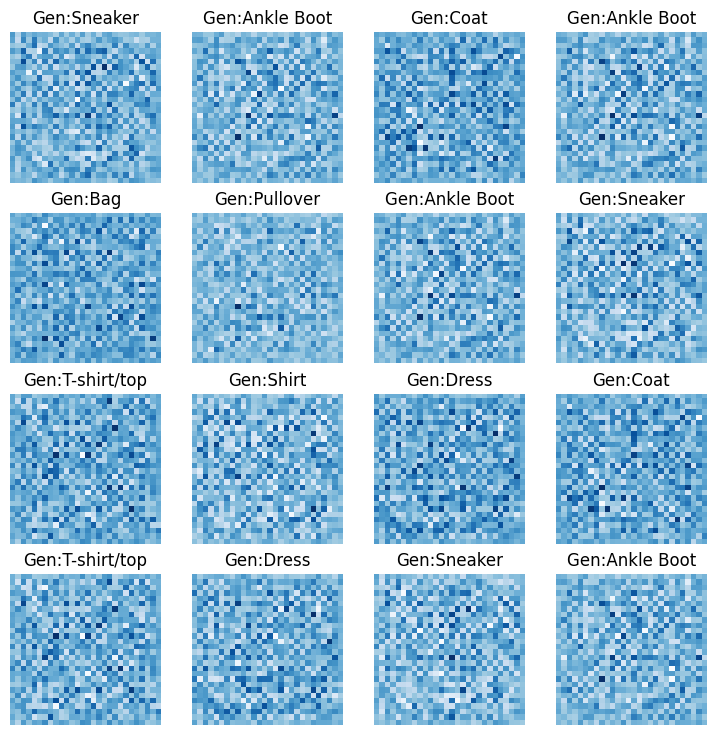

In [ ]:
gen_images = generator(fixed_noise, fixed_classes.to(DEVICE))
plot_gen_images(gen_images, fixed_classes)

In [ ]:
discriminator(gen_images.view(gen_images.shape[0], -1),  fixed_classes.to(DEVICE)).view(-1)

tensor([-0.0505, -0.0516, -0.0697, -0.0516, -0.0481, -0.0543, -0.0515, -0.0505,
        -0.0510, -0.0542, -0.0893, -0.0695, -0.0507, -0.0899, -0.0506, -0.0516],
       device='cuda:0', grad_fn=<ViewBackward0>)

### GAN обучение

Epoch:1 Iter: 500 ERRD_x: 0.0040 ERRD_z: 0.0025 errG: 0.2594 lr_D: 0.001000000 lr_G: 0.001000000
Epoch:1 Iter: 1000 ERRD_x: 0.0011 ERRD_z: 0.0011 errG: 0.2567 lr_D: 0.001000000 lr_G: 0.001000000
Epoch:1 Iter: 1500 ERRD_x: 0.0109 ERRD_z: 0.0022 errG: 0.1625 lr_D: 0.000995012 lr_G: 0.000999000
Epoch:1 Iter: 2000 ERRD_x: 0.0000 ERRD_z: 0.0060 errG: 0.3461 lr_D: 0.000990050 lr_G: 0.000998002
Epoch:1 Iter: 2500 ERRD_x: 0.0000 ERRD_z: 0.0009 errG: 0.2821 lr_D: 0.000980199 lr_G: 0.000996008
Epoch:1 Iter: 3000 ERRD_x: 0.0000 ERRD_z: 0.0036 errG: 0.1858 lr_D: 0.000970445 lr_G: 0.000994018
Epoch:1 Iter: 3500 ERRD_x: 0.0090 ERRD_z: 0.0009 errG: 0.2491 lr_D: 0.000955997 lr_G: 0.000991040


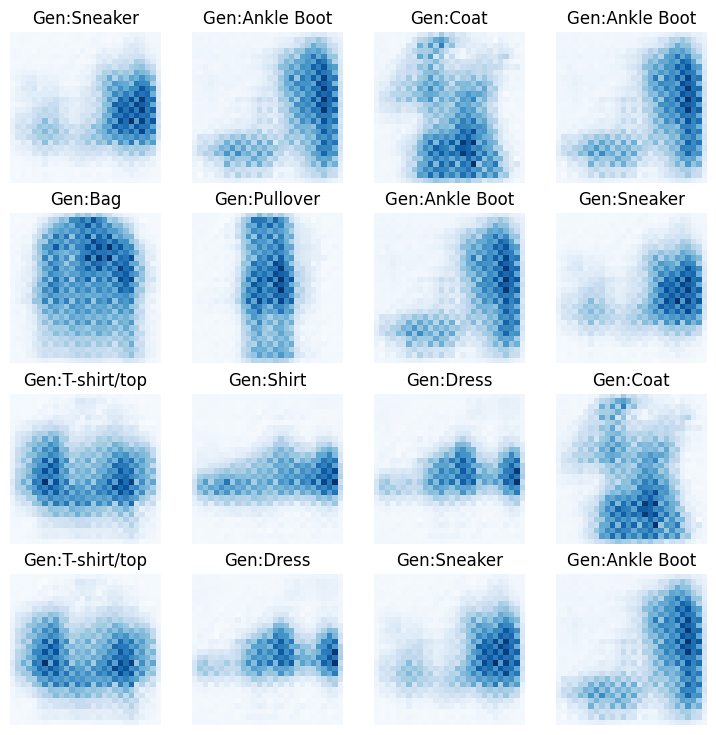

Epoch:2 Iter: 500 ERRD_x: 0.0001 ERRD_z: 0.0013 errG: 0.2511 lr_D: 0.000901411 lr_G: 0.000940077
Epoch:2 Iter: 1000 ERRD_x: 0.0001 ERRD_z: 0.0007 errG: 0.3295 lr_D: 0.000901411 lr_G: 0.000940077
Epoch:2 Iter: 1500 ERRD_x: 0.0153 ERRD_z: 0.0074 errG: 0.1614 lr_D: 0.000896916 lr_G: 0.000939138
Epoch:2 Iter: 2000 ERRD_x: 0.0007 ERRD_z: 0.0017 errG: 0.2437 lr_D: 0.000892442 lr_G: 0.000938199
Epoch:2 Iter: 2500 ERRD_x: 0.0059 ERRD_z: 0.0038 errG: 0.2109 lr_D: 0.000883562 lr_G: 0.000936324
Epoch:2 Iter: 3000 ERRD_x: 0.0073 ERRD_z: 0.0041 errG: 0.2768 lr_D: 0.000874771 lr_G: 0.000934454
Epoch:2 Iter: 3500 ERRD_x: 0.0389 ERRD_z: 0.0004 errG: 0.2655 lr_D: 0.000861747 lr_G: 0.000931654


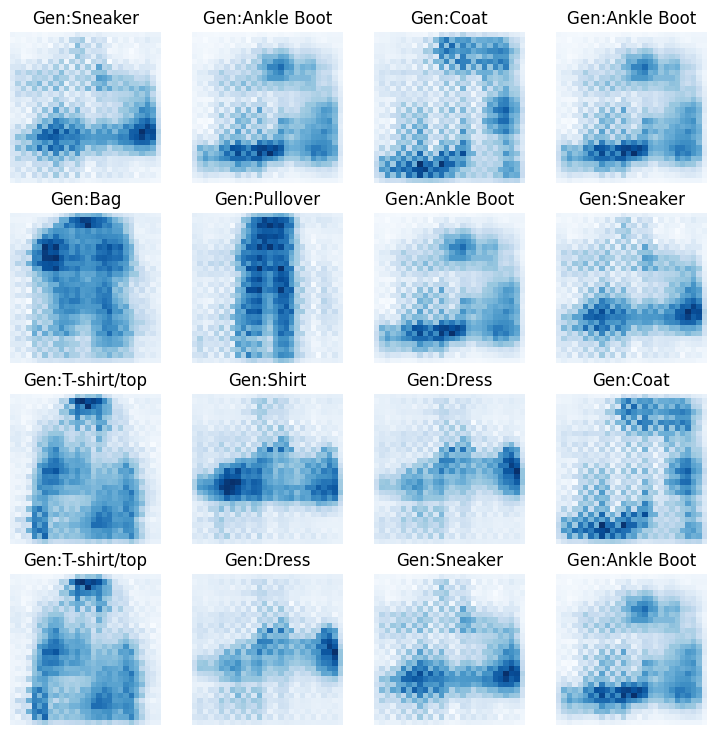

Epoch:3 Iter: 500 ERRD_x: 0.0005 ERRD_z: 0.0002 errG: 0.3181 lr_D: 0.000771915 lr_G: 0.000839558
Epoch:3 Iter: 1000 ERRD_x: 0.0002 ERRD_z: 0.0029 errG: 0.2328 lr_D: 0.000771915 lr_G: 0.000839558
Epoch:3 Iter: 1500 ERRD_x: 0.0013 ERRD_z: 0.0022 errG: 0.2825 lr_D: 0.000768065 lr_G: 0.000838719
Epoch:3 Iter: 2000 ERRD_x: 0.0015 ERRD_z: 0.0022 errG: 0.5824 lr_D: 0.000764235 lr_G: 0.000837880
Epoch:3 Iter: 2500 ERRD_x: 0.0000 ERRD_z: 0.0069 errG: 0.3609 lr_D: 0.000756630 lr_G: 0.000836206
Epoch:3 Iter: 3000 ERRD_x: 0.0000 ERRD_z: 0.0151 errG: 0.3921 lr_D: 0.000749102 lr_G: 0.000834535
Epoch:3 Iter: 3500 ERRD_x: 0.0003 ERRD_z: 0.0019 errG: 0.3987 lr_D: 0.000737949 lr_G: 0.000832036


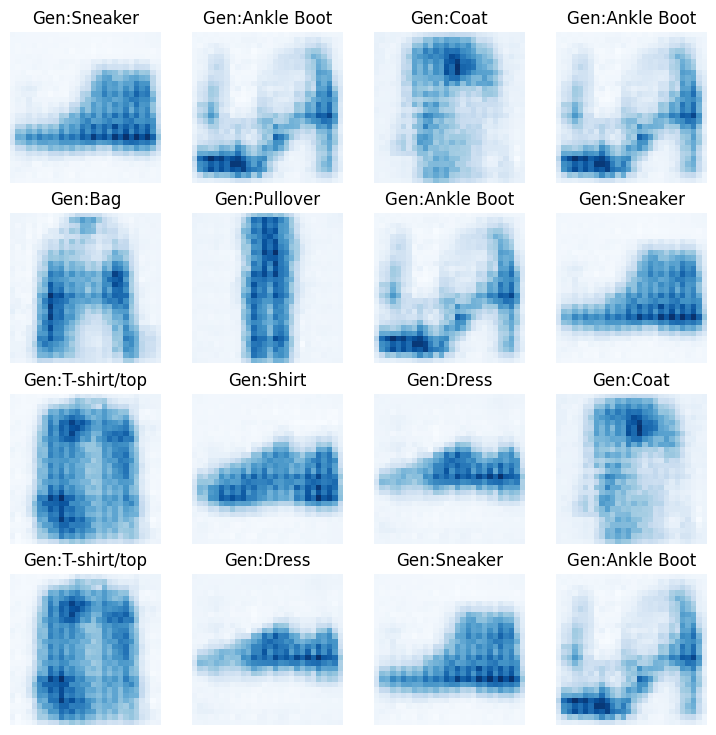

Epoch:4 Iter: 500 ERRD_x: 0.0045 ERRD_z: 0.0082 errG: 0.4410 lr_D: 0.000627971 lr_G: 0.000712297
Epoch:4 Iter: 1000 ERRD_x: 0.0009 ERRD_z: 0.0019 errG: 0.3652 lr_D: 0.000627971 lr_G: 0.000712297
Epoch:4 Iter: 1500 ERRD_x: 0.0014 ERRD_z: 0.0006 errG: 0.2775 lr_D: 0.000624839 lr_G: 0.000711585
Epoch:4 Iter: 2000 ERRD_x: 0.0862 ERRD_z: 0.0097 errG: 0.3178 lr_D: 0.000621723 lr_G: 0.000710874
Epoch:4 Iter: 2500 ERRD_x: 0.0012 ERRD_z: 0.0005 errG: 0.3864 lr_D: 0.000615537 lr_G: 0.000709454
Epoch:4 Iter: 3000 ERRD_x: 0.0221 ERRD_z: 0.0001 errG: 0.1744 lr_D: 0.000609412 lr_G: 0.000708036
Epoch:4 Iter: 3500 ERRD_x: 0.0003 ERRD_z: 0.0010 errG: 0.4386 lr_D: 0.000600339 lr_G: 0.000705915


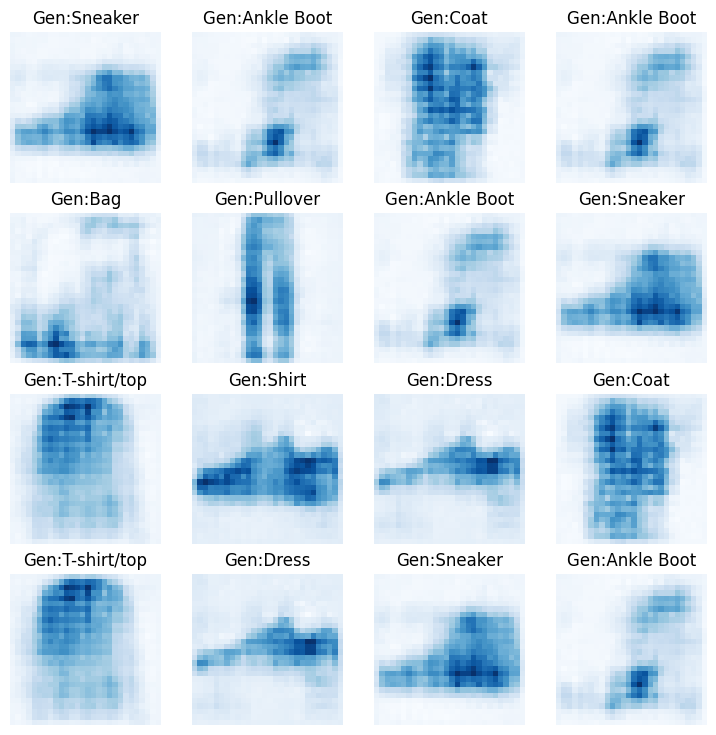

Epoch:5 Iter: 500 ERRD_x: 0.0000 ERRD_z: 0.0022 errG: 0.3148 lr_D: 0.000485326 lr_G: 0.000574111
Epoch:5 Iter: 1000 ERRD_x: 0.0217 ERRD_z: 0.0003 errG: 0.3306 lr_D: 0.000485326 lr_G: 0.000574111
Epoch:5 Iter: 1500 ERRD_x: 0.0006 ERRD_z: 0.0019 errG: 0.3709 lr_D: 0.000482906 lr_G: 0.000573537
Epoch:5 Iter: 2000 ERRD_x: 0.0000 ERRD_z: 0.0006 errG: 0.2820 lr_D: 0.000480497 lr_G: 0.000572964
Epoch:5 Iter: 2500 ERRD_x: 0.0048 ERRD_z: 0.0011 errG: 0.5635 lr_D: 0.000475716 lr_G: 0.000571819
Epoch:5 Iter: 3000 ERRD_x: 0.0002 ERRD_z: 0.0057 errG: 0.1934 lr_D: 0.000470983 lr_G: 0.000570676
Epoch:5 Iter: 3500 ERRD_x: 0.0051 ERRD_z: 0.0004 errG: 0.3119 lr_D: 0.000463971 lr_G: 0.000568967


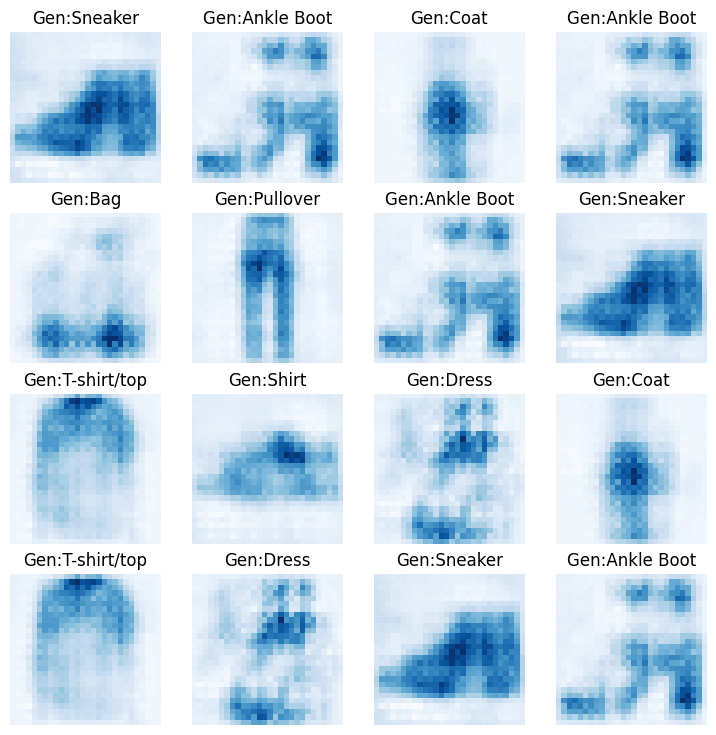

Epoch:6 Iter: 500 ERRD_x: 0.0000 ERRD_z: 0.0013 errG: 0.2650 lr_D: 0.000356329 lr_G: 0.000439596
Epoch:6 Iter: 1000 ERRD_x: 0.0003 ERRD_z: 0.0003 errG: 0.3234 lr_D: 0.000356329 lr_G: 0.000439596
Epoch:6 Iter: 1500 ERRD_x: 0.0020 ERRD_z: 0.0023 errG: 0.4231 lr_D: 0.000354552 lr_G: 0.000439156
Epoch:6 Iter: 2000 ERRD_x: 0.0003 ERRD_z: 0.0054 errG: 0.7485 lr_D: 0.000352783 lr_G: 0.000438717
Epoch:6 Iter: 2500 ERRD_x: 0.0002 ERRD_z: 0.0016 errG: 0.3523 lr_D: 0.000349273 lr_G: 0.000437841
Epoch:6 Iter: 3000 ERRD_x: 0.0236 ERRD_z: 0.0000 errG: 0.4830 lr_D: 0.000345798 lr_G: 0.000436966
Epoch:6 Iter: 3500 ERRD_x: 0.0035 ERRD_z: 0.0019 errG: 0.3266 lr_D: 0.000340650 lr_G: 0.000435657


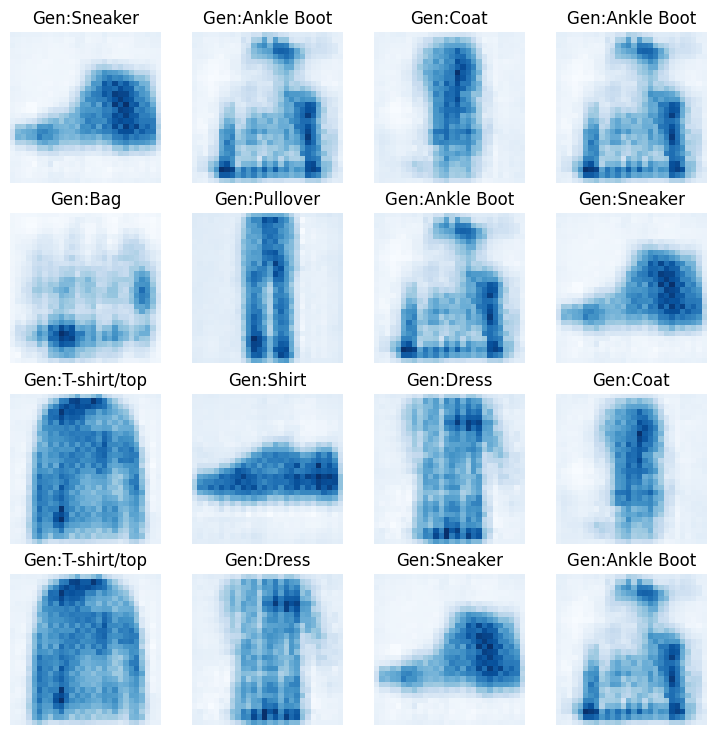

Epoch:7 Iter: 500 ERRD_x: 0.0003 ERRD_z: 0.0005 errG: 0.2812 lr_D: 0.000248538 lr_G: 0.000319768
Epoch:7 Iter: 1000 ERRD_x: 0.0029 ERRD_z: 0.0033 errG: 0.2099 lr_D: 0.000248538 lr_G: 0.000319768
Epoch:7 Iter: 1500 ERRD_x: 0.0004 ERRD_z: 0.0010 errG: 0.3169 lr_D: 0.000247298 lr_G: 0.000319448
Epoch:7 Iter: 2000 ERRD_x: 0.0003 ERRD_z: 0.0006 errG: 0.3031 lr_D: 0.000246065 lr_G: 0.000319129
Epoch:7 Iter: 2500 ERRD_x: 0.0006 ERRD_z: 0.0007 errG: 0.2803 lr_D: 0.000243616 lr_G: 0.000318491
Epoch:7 Iter: 3000 ERRD_x: 0.0005 ERRD_z: 0.0003 errG: 0.3408 lr_D: 0.000241192 lr_G: 0.000317855
Epoch:7 Iter: 3500 ERRD_x: 0.0017 ERRD_z: 0.0003 errG: 0.3817 lr_D: 0.000237601 lr_G: 0.000316903


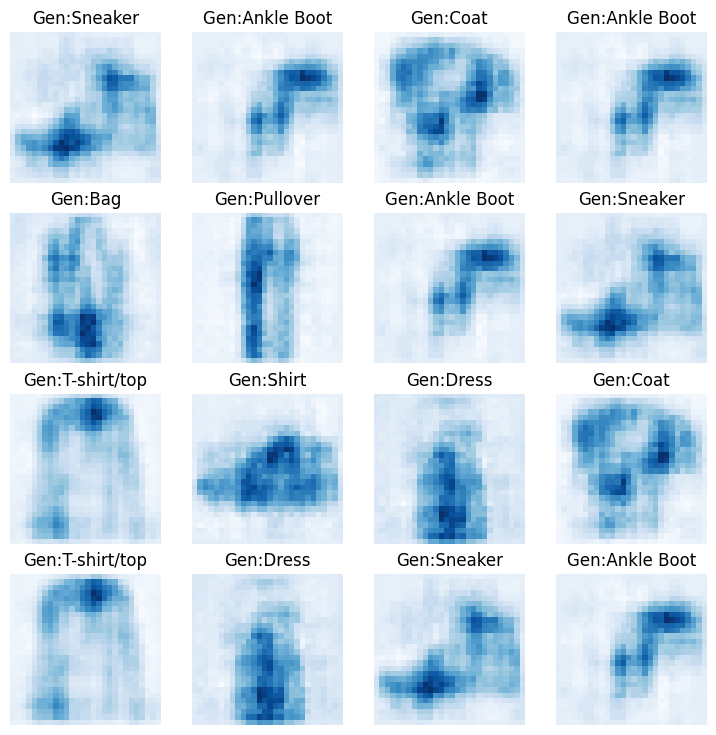

Epoch:8 Iter: 500 ERRD_x: 0.0004 ERRD_z: 0.0015 errG: 0.3392 lr_D: 0.000164686 lr_G: 0.000220973
Epoch:8 Iter: 1000 ERRD_x: 0.0000 ERRD_z: 0.0007 errG: 0.3480 lr_D: 0.000164686 lr_G: 0.000220973
Epoch:8 Iter: 1500 ERRD_x: 0.0000 ERRD_z: 0.0019 errG: 0.2602 lr_D: 0.000163865 lr_G: 0.000220753
Epoch:8 Iter: 2000 ERRD_x: 0.0089 ERRD_z: 0.0003 errG: 0.3118 lr_D: 0.000163047 lr_G: 0.000220532
Epoch:8 Iter: 2500 ERRD_x: 0.0073 ERRD_z: 0.0002 errG: 0.3972 lr_D: 0.000161425 lr_G: 0.000220091
Epoch:8 Iter: 3000 ERRD_x: 0.0001 ERRD_z: 0.0006 errG: 0.2218 lr_D: 0.000159819 lr_G: 0.000219652
Epoch:8 Iter: 3500 ERRD_x: 0.0001 ERRD_z: 0.0001 errG: 0.6475 lr_D: 0.000157439 lr_G: 0.000218994


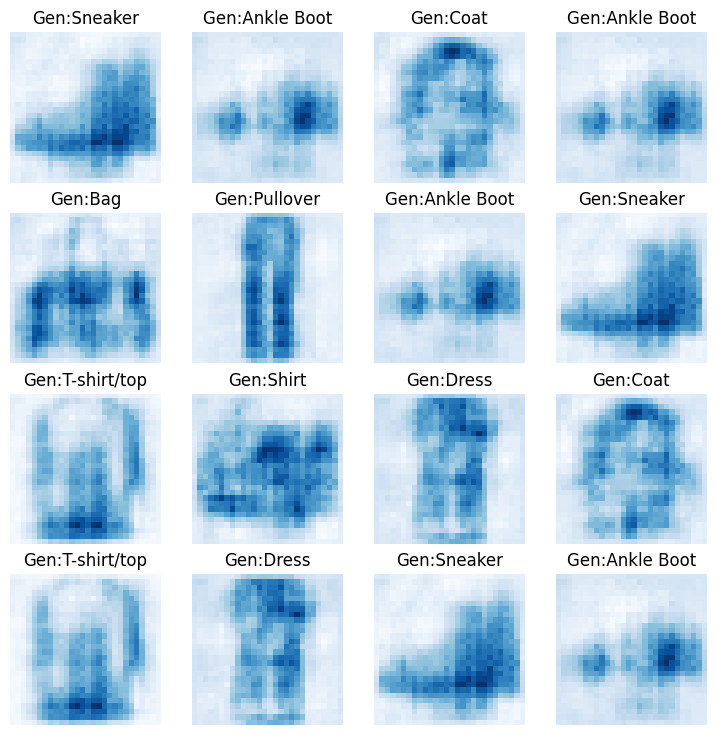

Epoch:9 Iter: 500 ERRD_x: 0.0009 ERRD_z: 0.0002 errG: 0.4585 lr_D: 0.000103668 lr_G: 0.000145067
Epoch:9 Iter: 1000 ERRD_x: 0.0000 ERRD_z: 0.0021 errG: 0.2751 lr_D: 0.000103668 lr_G: 0.000145067
Epoch:9 Iter: 1500 ERRD_x: 0.0139 ERRD_z: 0.0016 errG: 0.3007 lr_D: 0.000103151 lr_G: 0.000144922
Epoch:9 Iter: 2000 ERRD_x: 0.0003 ERRD_z: 0.0022 errG: 0.3187 lr_D: 0.000102637 lr_G: 0.000144777
Epoch:9 Iter: 2500 ERRD_x: 0.0000 ERRD_z: 0.0021 errG: 0.2537 lr_D: 0.000101615 lr_G: 0.000144488
Epoch:9 Iter: 3000 ERRD_x: 0.0006 ERRD_z: 0.0020 errG: 0.2650 lr_D: 0.000100604 lr_G: 0.000144199
Epoch:9 Iter: 3500 ERRD_x: 0.0000 ERRD_z: 0.0010 errG: 0.2841 lr_D: 0.000099106 lr_G: 0.000143767


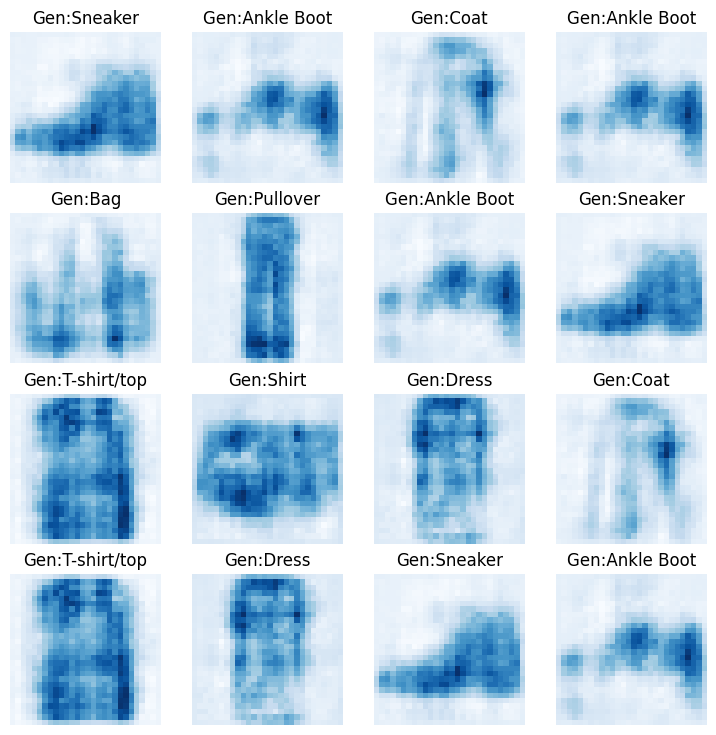

Epoch:10 Iter: 500 ERRD_x: 0.0005 ERRD_z: 0.0015 errG: 0.2225 lr_D: 0.000061995 lr_G: 0.000090473
Epoch:10 Iter: 1000 ERRD_x: 0.0013 ERRD_z: 0.0010 errG: 0.3194 lr_D: 0.000061995 lr_G: 0.000090473
Epoch:10 Iter: 1500 ERRD_x: 0.0013 ERRD_z: 0.0021 errG: 0.2737 lr_D: 0.000061686 lr_G: 0.000090383
Epoch:10 Iter: 2000 ERRD_x: 0.0005 ERRD_z: 0.0015 errG: 0.2411 lr_D: 0.000061378 lr_G: 0.000090293
Epoch:10 Iter: 2500 ERRD_x: 0.0000 ERRD_z: 0.0015 errG: 0.2340 lr_D: 0.000060767 lr_G: 0.000090112
Epoch:10 Iter: 3000 ERRD_x: 0.0003 ERRD_z: 0.0013 errG: 0.2497 lr_D: 0.000060163 lr_G: 0.000089932
Epoch:10 Iter: 3500 ERRD_x: 0.0002 ERRD_z: 0.0011 errG: 0.2437 lr_D: 0.000059267 lr_G: 0.000089663


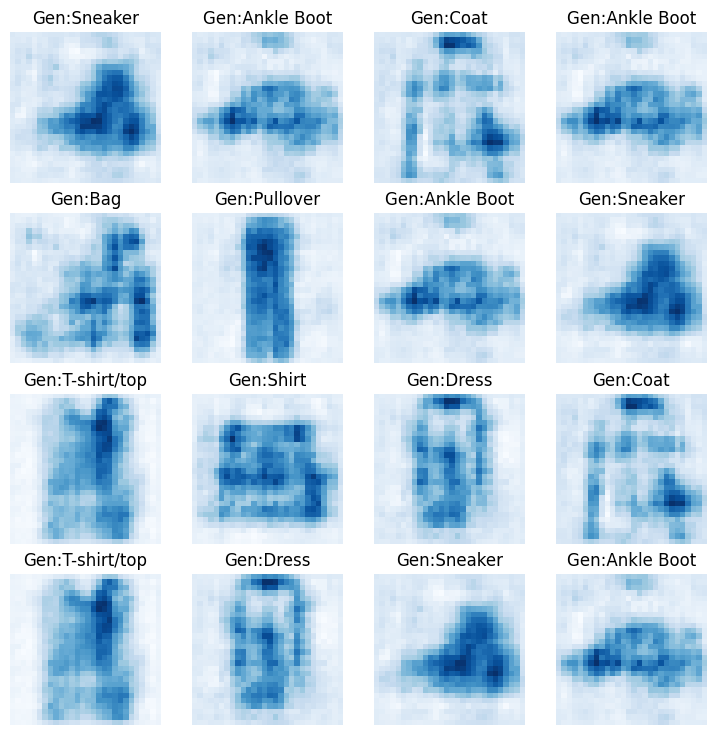

Epoch:11 Iter: 500 ERRD_x: 0.0000 ERRD_z: 0.0009 errG: 0.2752 lr_D: 0.000035220 lr_G: 0.000053604
Epoch:11 Iter: 1000 ERRD_x: 0.0002 ERRD_z: 0.0010 errG: 0.2820 lr_D: 0.000035220 lr_G: 0.000053604
Epoch:11 Iter: 1500 ERRD_x: 0.0006 ERRD_z: 0.0005 errG: 0.3090 lr_D: 0.000035045 lr_G: 0.000053550
Epoch:11 Iter: 2000 ERRD_x: 0.0008 ERRD_z: 0.0027 errG: 0.2378 lr_D: 0.000034870 lr_G: 0.000053497
Epoch:11 Iter: 2500 ERRD_x: 0.0015 ERRD_z: 0.0008 errG: 0.3064 lr_D: 0.000034523 lr_G: 0.000053390
Epoch:11 Iter: 3000 ERRD_x: 0.0132 ERRD_z: 0.0007 errG: 0.2928 lr_D: 0.000034179 lr_G: 0.000053283
Epoch:11 Iter: 3500 ERRD_x: 0.0010 ERRD_z: 0.0012 errG: 0.2598 lr_D: 0.000033670 lr_G: 0.000053124


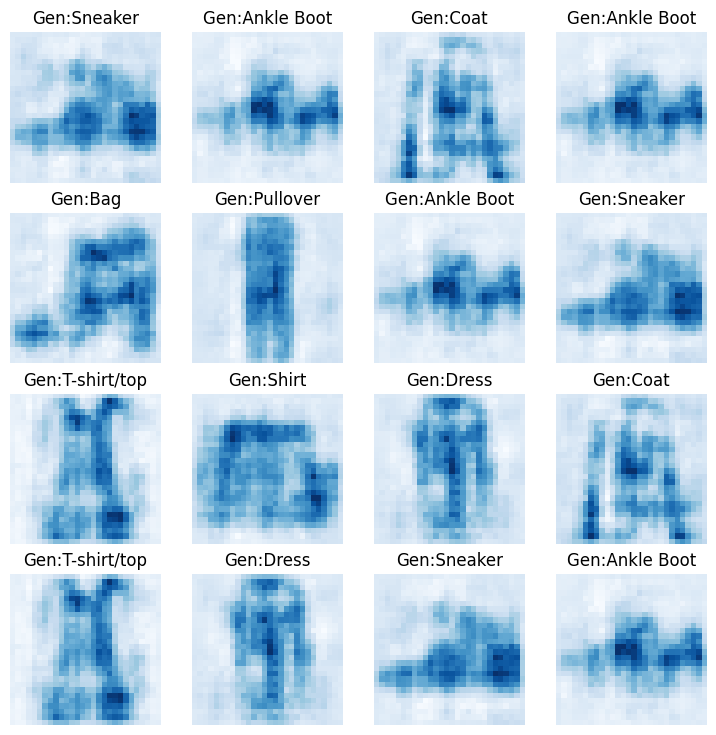

Epoch:12 Iter: 500 ERRD_x: 0.0247 ERRD_z: 0.0012 errG: 0.2416 lr_D: 0.000019009 lr_G: 0.000030171
Epoch:12 Iter: 1000 ERRD_x: 0.0005 ERRD_z: 0.0011 errG: 0.2803 lr_D: 0.000019009 lr_G: 0.000030171
Epoch:12 Iter: 1500 ERRD_x: 0.0021 ERRD_z: 0.0012 errG: 0.2408 lr_D: 0.000018914 lr_G: 0.000030141
Epoch:12 Iter: 2000 ERRD_x: 0.0039 ERRD_z: 0.0009 errG: 0.2668 lr_D: 0.000018820 lr_G: 0.000030111
Epoch:12 Iter: 2500 ERRD_x: 0.0006 ERRD_z: 0.0008 errG: 0.2562 lr_D: 0.000018632 lr_G: 0.000030051
Epoch:12 Iter: 3000 ERRD_x: 0.0078 ERRD_z: 0.0009 errG: 0.2678 lr_D: 0.000018447 lr_G: 0.000029991
Epoch:12 Iter: 3500 ERRD_x: 0.0066 ERRD_z: 0.0029 errG: 0.2404 lr_D: 0.000018172 lr_G: 0.000029901


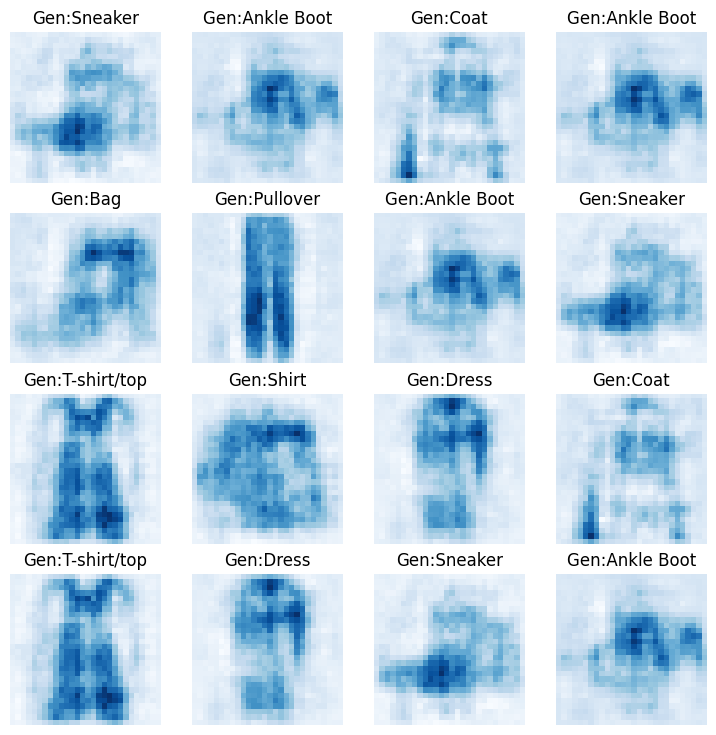

Epoch:13 Iter: 500 ERRD_x: 0.0003 ERRD_z: 0.0019 errG: 0.2219 lr_D: 0.000009746 lr_G: 0.000016133
Epoch:13 Iter: 1000 ERRD_x: 0.0062 ERRD_z: 0.0015 errG: 0.2478 lr_D: 0.000009746 lr_G: 0.000016133
Epoch:13 Iter: 1500 ERRD_x: 0.0139 ERRD_z: 0.0014 errG: 0.2355 lr_D: 0.000009698 lr_G: 0.000016117
Epoch:13 Iter: 2000 ERRD_x: 0.0017 ERRD_z: 0.0012 errG: 0.2467 lr_D: 0.000009649 lr_G: 0.000016101
Epoch:13 Iter: 2500 ERRD_x: 0.0005 ERRD_z: 0.0016 errG: 0.2434 lr_D: 0.000009553 lr_G: 0.000016069
Epoch:13 Iter: 3000 ERRD_x: 0.0006 ERRD_z: 0.0020 errG: 0.2181 lr_D: 0.000009458 lr_G: 0.000016037
Epoch:13 Iter: 3500 ERRD_x: 0.0006 ERRD_z: 0.0014 errG: 0.2522 lr_D: 0.000009317 lr_G: 0.000015989


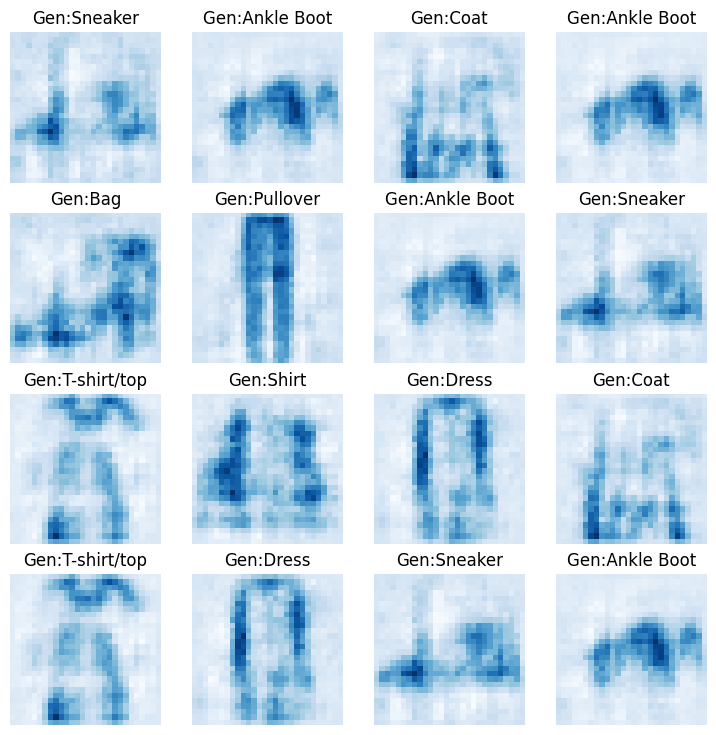

Epoch:14 Iter: 500 ERRD_x: 0.0001 ERRD_z: 0.0020 errG: 0.2362 lr_D: 0.000004747 lr_G: 0.000008195
Epoch:14 Iter: 1000 ERRD_x: 0.0007 ERRD_z: 0.0020 errG: 0.2316 lr_D: 0.000004747 lr_G: 0.000008195
Epoch:14 Iter: 1500 ERRD_x: 0.0001 ERRD_z: 0.0015 errG: 0.2251 lr_D: 0.000004724 lr_G: 0.000008187
Epoch:14 Iter: 2000 ERRD_x: 0.0094 ERRD_z: 0.0013 errG: 0.2471 lr_D: 0.000004700 lr_G: 0.000008179
Epoch:14 Iter: 2500 ERRD_x: 0.0109 ERRD_z: 0.0024 errG: 0.2267 lr_D: 0.000004653 lr_G: 0.000008163
Epoch:14 Iter: 3000 ERRD_x: 0.0001 ERRD_z: 0.0019 errG: 0.2482 lr_D: 0.000004607 lr_G: 0.000008146
Epoch:14 Iter: 3500 ERRD_x: 0.0098 ERRD_z: 0.0021 errG: 0.2337 lr_D: 0.000004538 lr_G: 0.000008122


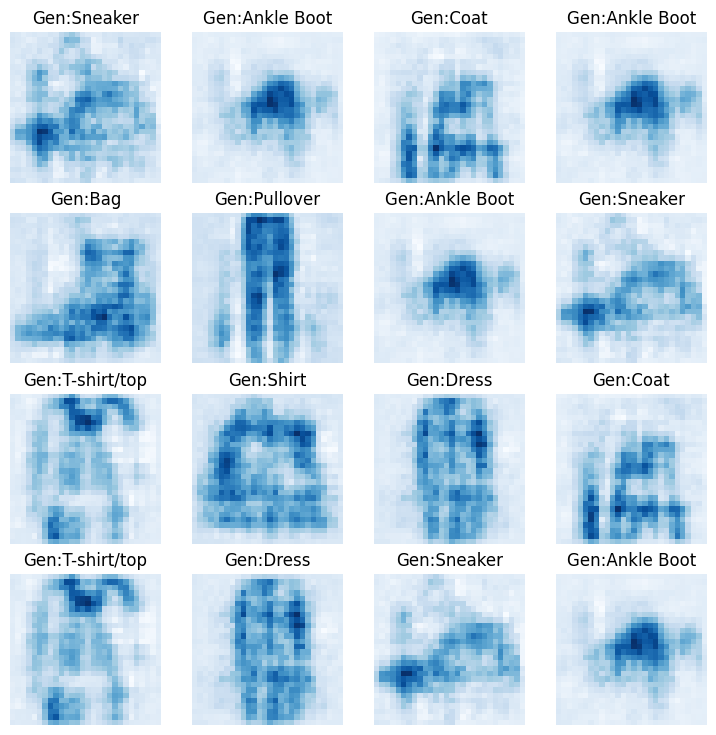

Epoch:15 Iter: 500 ERRD_x: 0.0010 ERRD_z: 0.0019 errG: 0.2367 lr_D: 0.000002197 lr_G: 0.000003955
Epoch:15 Iter: 1000 ERRD_x: 0.0004 ERRD_z: 0.0017 errG: 0.2543 lr_D: 0.000002197 lr_G: 0.000003955
Epoch:15 Iter: 1500 ERRD_x: 0.0020 ERRD_z: 0.0023 errG: 0.2380 lr_D: 0.000002186 lr_G: 0.000003951
Epoch:15 Iter: 2000 ERRD_x: 0.0001 ERRD_z: 0.0030 errG: 0.2097 lr_D: 0.000002175 lr_G: 0.000003947
Epoch:15 Iter: 2500 ERRD_x: 0.0013 ERRD_z: 0.0024 errG: 0.2141 lr_D: 0.000002153 lr_G: 0.000003939
Epoch:15 Iter: 3000 ERRD_x: 0.0009 ERRD_z: 0.0019 errG: 0.2272 lr_D: 0.000002132 lr_G: 0.000003931
Epoch:15 Iter: 3500 ERRD_x: 0.0194 ERRD_z: 0.0020 errG: 0.2094 lr_D: 0.000002100 lr_G: 0.000003919


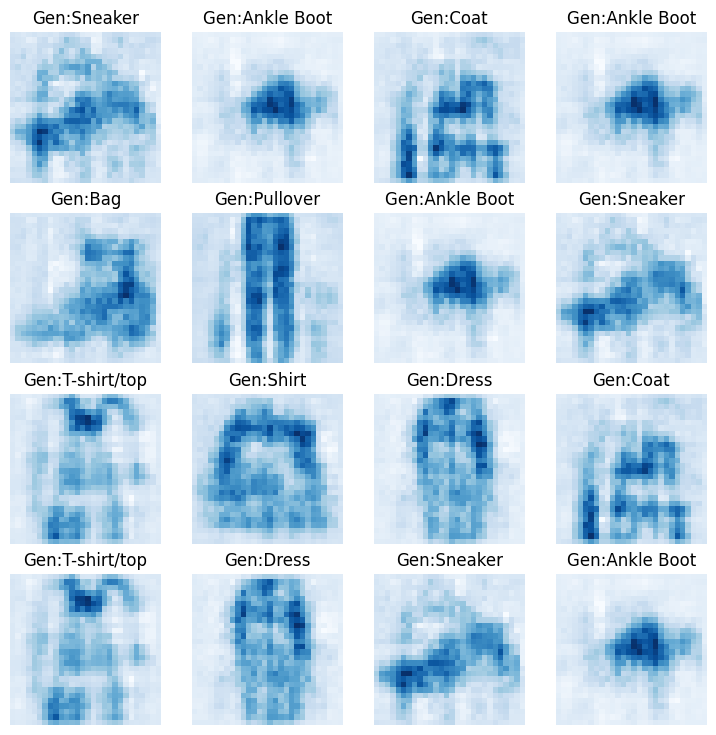

In [ ]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERR_G = np.zeros(config.num_epochs)
N = len(dataloader)


# Loss weight for gradient penalty
lambda_gp = 10

for epoch in range(config.num_epochs):

    optim_D.param_groups[0]['lr'] *=  0.95**epoch
    optim_G.param_groups[0]['lr'] *=  0.95**epoch

    for iteration, (images, cat) in enumerate(dataloader):
        optim_D.param_groups[0]['lr'] *=  0.99999**(iteration//1000)


        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######

        discriminator.zero_grad()

        cls_images =  cat.to(DEVICE)

        # real
        label.data.fill_(real_label)
        input_data = images.to(DEVICE)
        output = discriminator(input_data.view(gen_images.shape[0], -1), cls_images).view(-1)
        errD_x = criterion(output, label)
        errD_x = errD_x/config.batch_size
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise, cls_images)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach().view(gen_images.shape[0], -1), cls_images).view(-1)
        errD_z = criterion(output, label)
        errD_z = errD_z/config.batch_size
        ERRD_z[epoch] += errD_z.item()

        errD_z.backward()
        optim_D.step()


        # clip critic weights between -0.01, 0.01
        for p in discriminator.parameters():
            p.data.clamp_(-0.1, 0.1)


        #######
        # Generator stage: maximize log(D(G(x))
        #######

        # Train the generator every n_critic steps
        if iteration % config.n_critic == 0:

            optim_G.param_groups[0]['lr'] *=  0.99999**(iteration//1000)
            generator.zero_grad()

            label.data.fill_(real_label)
            output = discriminator(fake.view(gen_images.shape[0], -1), cls_images).view(-1)
            errG = criterion(output, label)
            errG = errG/config.batch_size
            ERR_G[epoch] += errG.item()

            errG.backward()
            optim_G.step()

        if (iteration+1) % config.print_freq == 0:  #
            print('Epoch:{} Iter: {} ERRD_x: {:.4f} ERRD_z: {:.4f} errG: {:.4f} lr_D: {:.9f} lr_G: {:.9f}'.format(epoch+1,
                                iteration+1,
                                errD_x.item(),
                                errD_z.item(),
                                errG.item(),
                                optim_D.param_groups[0]['lr'],
                                optim_G.param_groups[0]['lr']
                                )
            )


        # Show result with fix_noise
        gen_images = generator(fixed_noise, fixed_classes.to(DEVICE))
        if iteration == N-1: plot_gen_images(gen_images, fixed_classes)

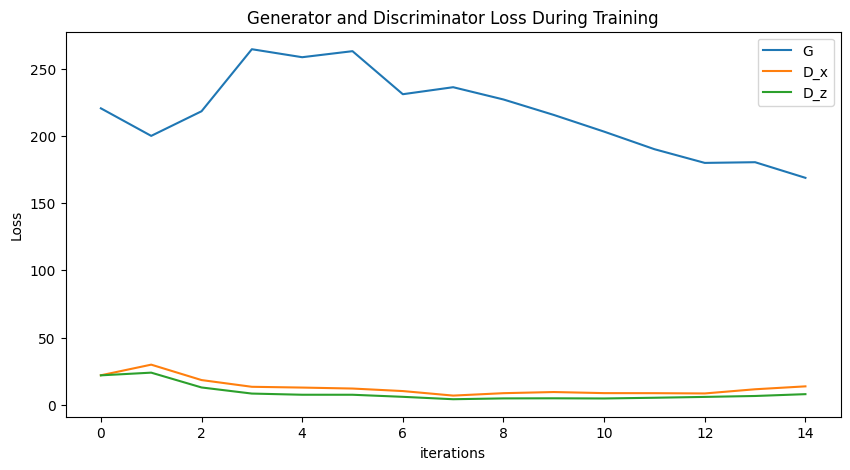

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(ERR_G,label="G")
plt.plot(ERRD_x,label="D_x")
plt.plot(ERRD_z,label="D_z")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

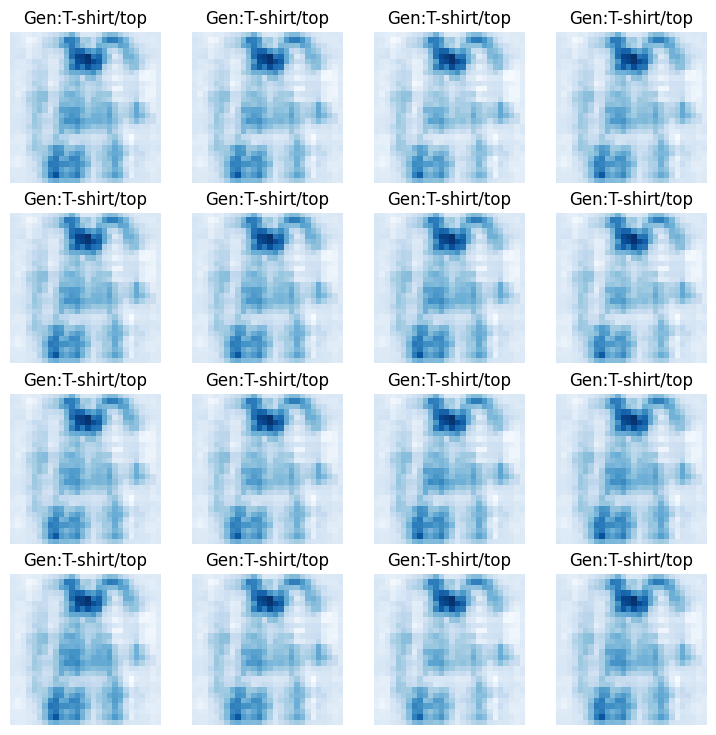

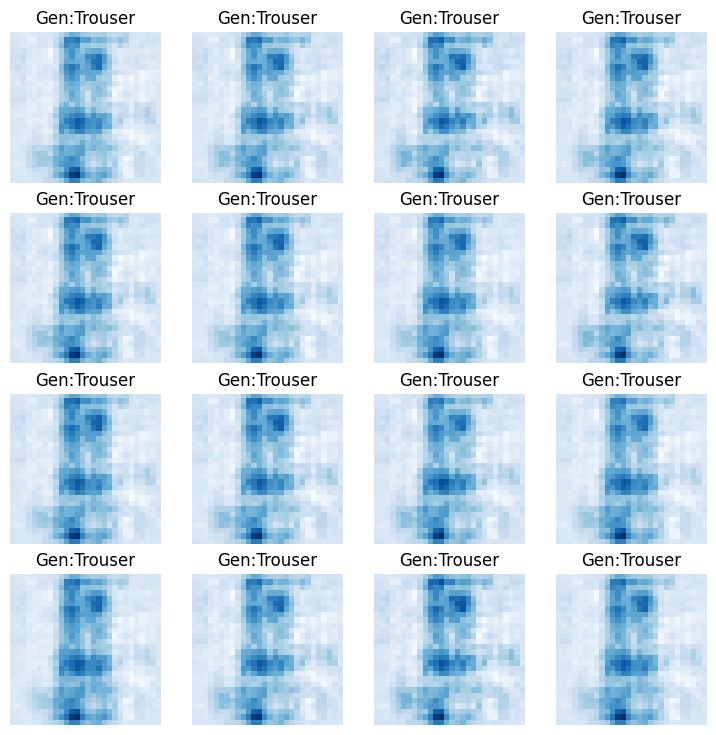

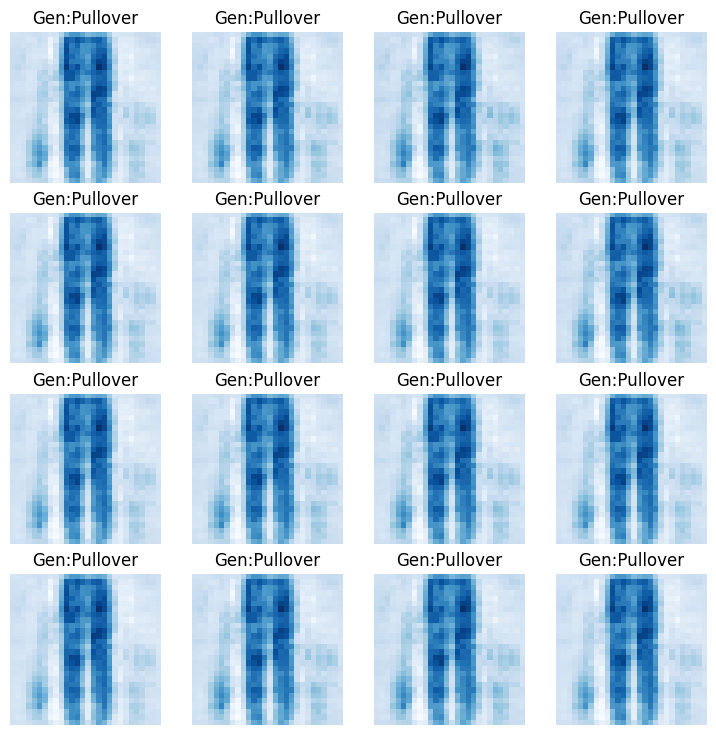

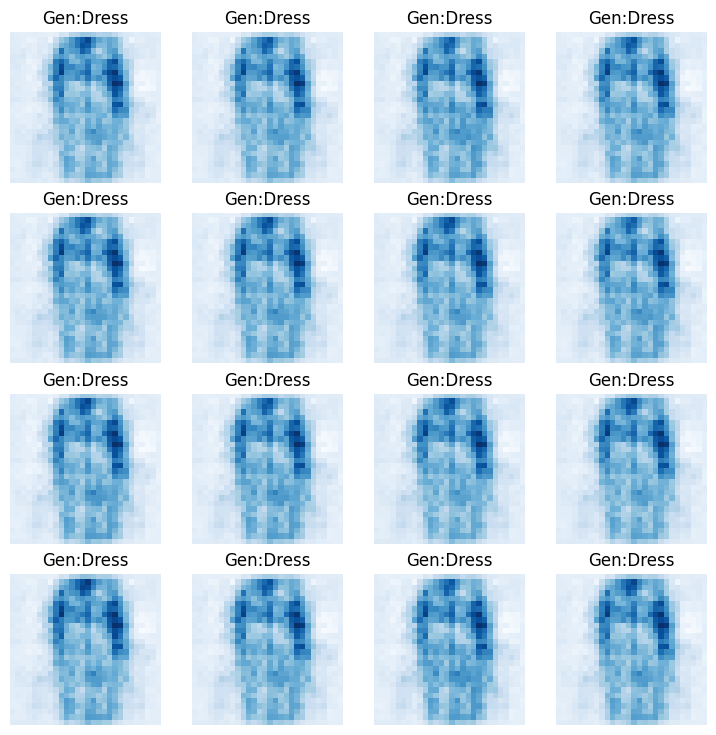

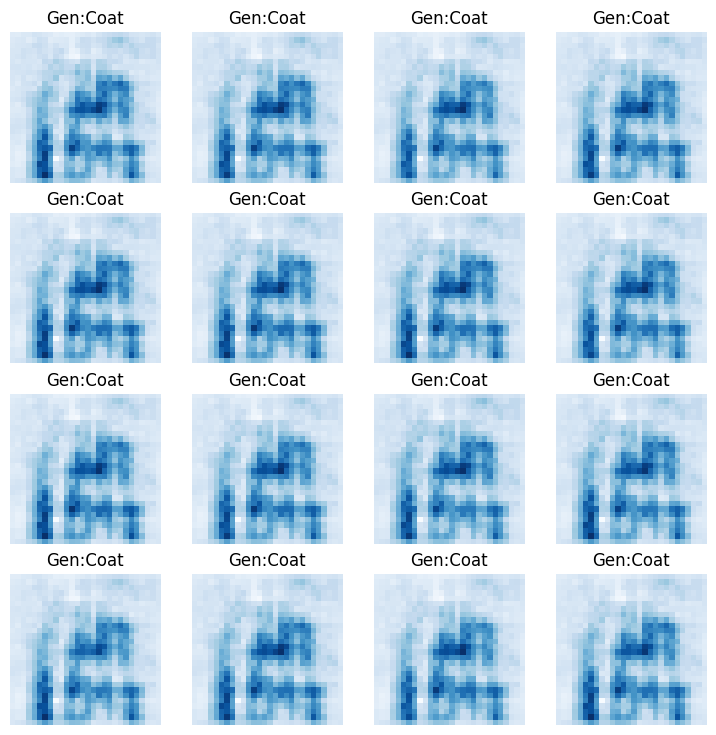

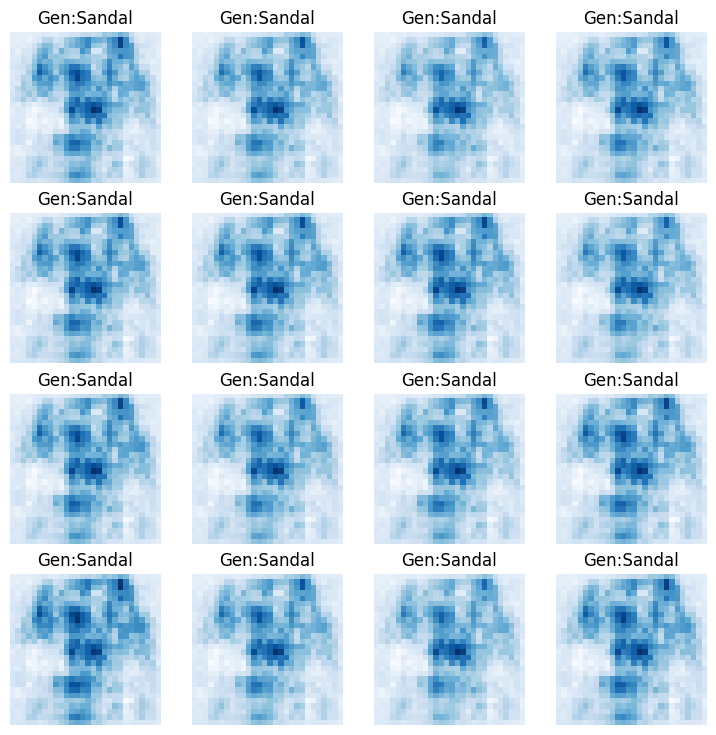

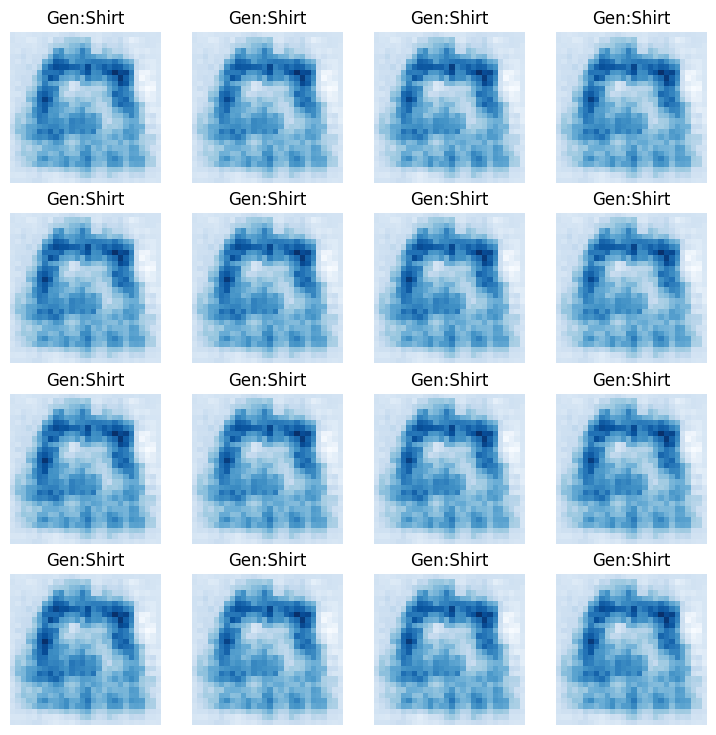

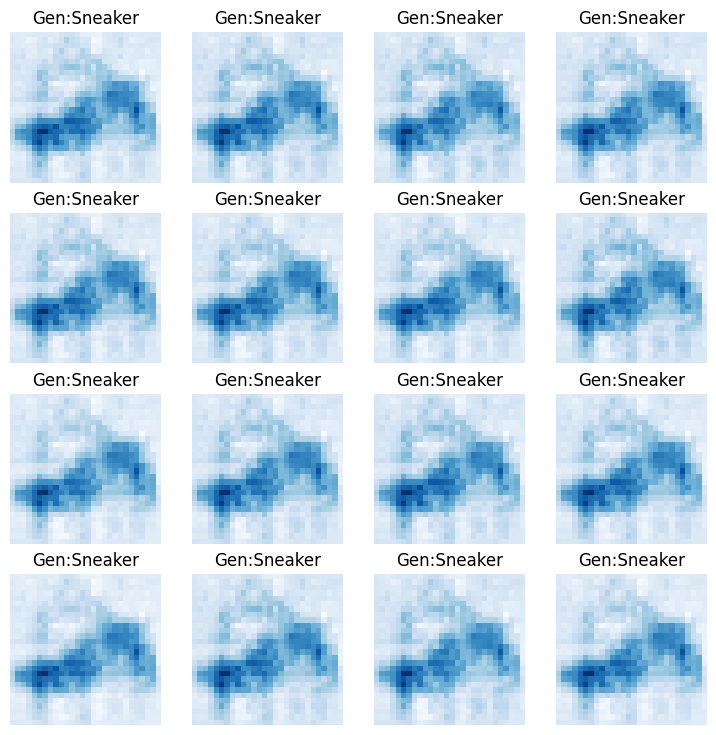

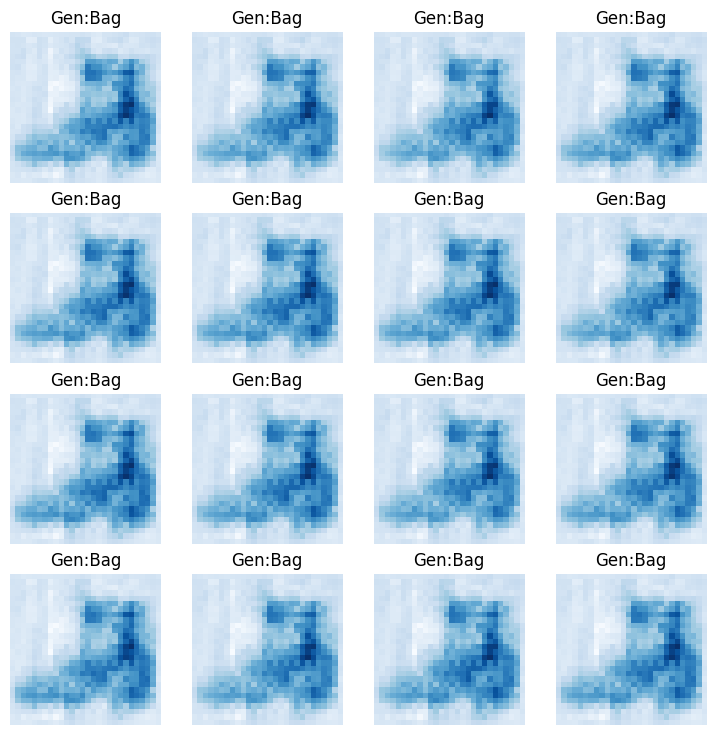

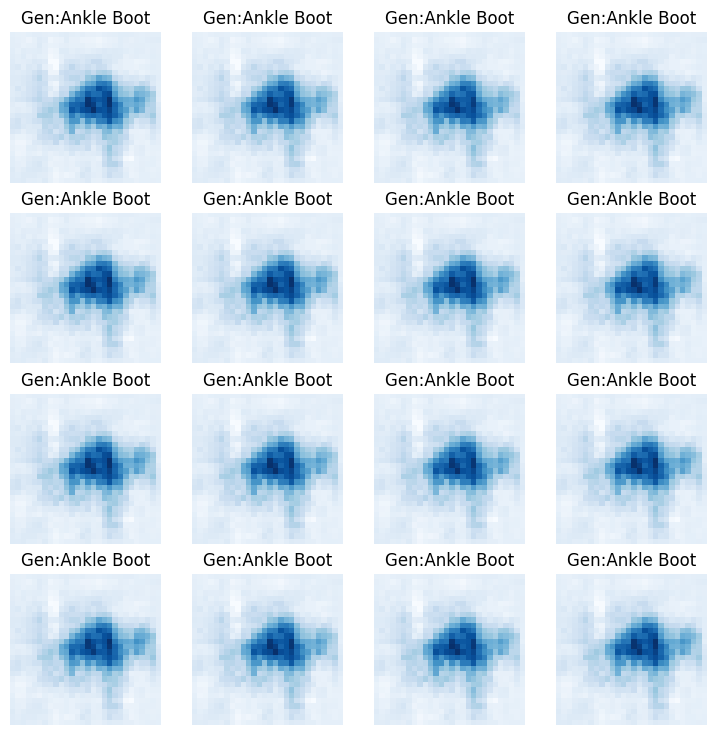

In [ ]:
noise = torch.concat([torch.randn(1, 1, IMG_ROWS, IMG_COLS) for _ in range(16)], axis = 0)
noise = Variable(noise).to(DEVICE)

for cls in range(10):
  gen_images = generator(noise, cls*torch.ones((16), dtype=torch.int).to(DEVICE))
  plot_gen_images(gen_images, cls*torch.ones((16), dtype=torch.int))
  print()

# Комментарий

- Построен генератор на основе Conv автоэнкодера

- Условная генерация работает, стало появляться разнообразие в генерации.

- Добавлено изменение шага обучения

- Разделено обучение генератора и критика(дискриминатора), и шаг у них тоже разный

- Появились Сандали уже


